# Explaining inferences to highlight PCB default

<img src="https://github.com/databricks-demos/dbdemos-resources/blob/main/images/product/computer-vision/deeplearning-cv-pcb-explainer.png?raw=true" width="500px" style="float: right"/>


Knowing that a PCB has been flagged as `damaged` by the model is a great first step. 

Being able to highlight which part is considered as damaged in the picture can help further, providing extra information to the operator.

This falls into the domain of model explainability. The most popular package for explanation are SHAP or LIME. 

In this notebook, we'll use SHAP to explore how we can explain our huggingface pipeline prediction.


<!-- Collect usage data (view). Remove it to disable collection. View README for more details.  -->
<img width="1px" src="https://ppxrzfxige.execute-api.us-west-2.amazonaws.com/v1/analytics?category=data-science&org_id=1549883858499596&notebook=%2F04-explaining-inference&demo_name=computer-vision-pcb&event=VIEW&path=%2F_dbdemos%2Fdata-science%2Fcomputer-vision-pcb%2F04-explaining-inference&version=1">

### A cluster has been created for this demo
To run this demo, just select the cluster `dbdemos-computer-vision-pcb-shawnzou2020` from the dropdown menu ([open cluster configuration](https://dbc-abdbb8e0-f50f.cloud.databricks.com/#setting/clusters/0410-040209-qt57lxc5/configuration)). <br />
*Note: If the cluster was deleted after 30 days, you can re-create it with `dbdemos.create_cluster('computer-vision-pcb')` or re-install the demo: `dbdemos.install('computer-vision-pcb')`*

In [0]:
%pip install opencv-python==4.8.0.74 numpy==1.21.5 shap==0.41.0

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 32.4 MB/s eta 0:00:00
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
from mlflow.store.artifact.models_artifact_repo import ModelsArtifactRepository
requirements_path = ModelsArtifactRepository("models:/dbdemos_pcb_classification/Production").download_artifacts(artifact_path="requirements.txt") # download model requirement from remote registry

In [0]:
%pip install -r $requirements_path

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
  Using cached mlflow-2.11.0-py3-none-any.whl (19.7 MB)
  Using cached docker-7.0.0-py3-none-any.whl (147 kB)
  Using cached alembic-1.13.1-py3-none-any.whl (233 kB)
  Using cached graphene-3.3-py2.py3-none-any.whl (128 kB)
  Using cached querystring_parser-1.2.4-py2.py3-none-any.whl (7.9 kB)
  Using cached aniso8601-9.0.1-py2.py3-none-any.whl (52 kB)
  Using cached graphql_relay-3.2.0-py3-none-any.whl (16 kB)
  Using cached graphql_core-3.2.3-py3-none-any.whl (202 kB)
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
%run ./_resources/00-init $reset_all_data=false $db=dbdemos $catalog=manufacturing_pcb

USE CATALOG `manufacturing_pcb`
using cloud_storage_path /Users/quentin.ambard@databricks.com/demos/manufacturing_pcb_dbdemos
using catalog.database `manufacturing_pcb`.`dbdemos`


data already existing. Run with reset_all_data=true to force a data cleanup for your local demo.


In [0]:
model_uri = "models:/dbdemos_pcb_classification/Production"
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
pipeline = mlflow.transformers.load_model(model_uri, device=device)
print(f"Model loaded from {model_uri} to device {device}")

2024/03/04 22:27:57 INFO mlflow.transformers: 'models:/dbdemos_pcb_classification/Production' resolved as 'dbfs://databricks/databricks/mlflow-registry/329ad5292e104cf187af92453f5bfa46/models/model'
/databricks/python/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Model loaded from models:/dbdemos_pcb_classification/Production to device cuda:0


In [0]:
df = spark.read.table("training_dataset_augmented").limit(50).toPandas()

In [0]:
def nhwc_to_nchw(x: torch.Tensor) -> torch.Tensor:
    return x if x.shape[1] == 3 else x.permute(0, 3, 1, 2)

def nchw_to_nhwc(x: torch.Tensor) -> torch.Tensor:
    return x if x.shape[3] == 3 else x.permute(0, 2, 3, 1)

In [0]:
import io
from PIL import Image
import shap
import torchvision.transforms as tf
from torchvision.transforms.functional import to_tensor
mlflow.autolog(disable=True)
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
transform = tf.Compose([
    tf.Lambda(lambda b: to_tensor(Image.open(io.BytesIO(b)))[None, :]),
    tf.Lambda(nhwc_to_nchw),
    tf.Resize((pipeline.image_processor.size['height'], pipeline.image_processor.size['width'])),
    tf.Normalize(mean=pipeline.image_processor.image_mean, std=pipeline.image_processor.image_std),
    tf.Lambda(nchw_to_nhwc),
])
inv_transform= tf.Compose([
    tf.Lambda(nhwc_to_nchw),
    tf.Normalize(mean = (-1 * np.array(pipeline.image_processor.image_mean) / np.array(pipeline.image_processor.image_std)).tolist(), 
                 std = (1 / np.array(pipeline.image_processor.image_std)).tolist()),
    tf.Lambda(nchw_to_nhwc),
])

#N
def hf_model_wrapper(img_vector):
  img_vector = torch.from_numpy(img_vector)
  revert_img_back = img_vector.permute(0, 3, 1, 2).to(device)
  output = pipeline.model(revert_img_back)
  return output.logits

class_names = ['damaged', 'normal']
mask_size = transform(df.iloc[0]['content'])[0].size()
masker_blur = shap.maskers.Image("blur(128,128)", mask_size)

# create an explainer with model and image masker
explainer = shap.Explainer(hf_model_wrapper, masker_blur, output_names=class_names)


def explain_image(image_to_explain, explainer, class_names):
  topk = 4
  batch_size = 50
  n_evals = 10000
  # feed only one image
  # here we explain two images using 100 evaluations of the underlying model to estimate the SHAP values
  shap_values = explainer(image_to_explain, max_evals=n_evals, batch_size=batch_size,
                          outputs=shap.Explanation.argsort.flip[:topk])
  
  shap_values.data = inv_transform(shap_values.data).cpu().numpy()
  shap_values.values = [val for val in np.moveaxis(shap_values.values,-1, 0)]

  shap.image_plot(shap_values=shap_values.values, pixel_values=shap_values.data, labels=class_names)

"is" with a literal. Did you mean "=="?
"is" with a literal. Did you mean "=="?
"is" with a literal. Did you mean "=="?
"is" with a literal. Did you mean "=="?
"is not" with a literal. Did you mean "!="?
"is not" with a literal. Did you mean "!="?


## Evaluating a damaged PCB 
We can see in red the damaged part (clearly identifiable in the picture )

Prediction for image 010.JPG: [{'score': 0.999804675579071, 'label': 'damaged'}, {'score': 0.00019532146689016372, 'label': 'normal'}]


  0%|          | 0/9998 [00:00<?, ?it/s]

Partition explainer: 2it [00:43, 43.64s/it]               


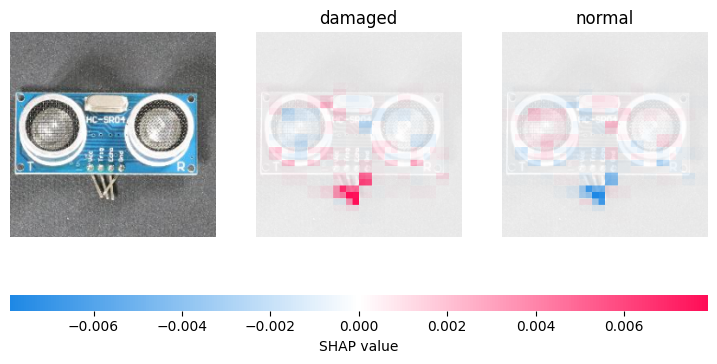

In [0]:
# We can clearly see in red the part where the anomaly is, and in blue its oposite (not contributing to 'normal').
test = spark.read.table("training_dataset_augmented").where("filename = '010.JPG'").toPandas()
image_bytes = test.iloc[0]['content']
predictions =  pipeline(Image.open(io.BytesIO(image_bytes)))
print(f"Prediction for image 010.JPG: {predictions}")

explain_image(transform(image_bytes), explainer, class_names)

## Conclusion

Not only we can predict our default, but we can also understand where they are and help resolving default!

### Going further

Learn how to implement a Computer Vision model with Databricks and pytorch lightning: [05-ADVANCED-pytorch-training-and-inference]($./05-ADVANCED-pytorch-training-and-inference)